In [1]:
import os
import pandas as pd

In [2]:
def load_data(years, base_dir, file_name):
    dfs = []
    for year in years:
        print(f"Loading {file_name} for {year}...")
        file_path = os.path.join(base_dir, f"GA-{year}/GA/{file_name}")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df.columns = df.columns.str.lower()
            
            # Handle NIBRS_OFFENSE.csv inconsistencies
            if file_name == "NIBRS_OFFENSE.csv":
                if 'offense_type_id' in df.columns:
                    # For 2018-2020: Map offense_type_id to offense_code using offense_type table
                    offense_type_df = pd.read_csv(os.path.join(base_dir, f"GA-{year}/GA/NIBRS_OFFENSE_TYPE.csv"))
                    offense_type_df.columns = offense_type_df.columns.str.lower()
                    df = df.merge(offense_type_df[['offense_type_id', 'offense_code']], on='offense_type_id', how='left')

            df['data_year'] = year
            dfs.append(df)
    
    return pd.concat(dfs, ignore_index=True)


In [3]:
# Load specific datasets
years = [2018, 2019, 2021, 2022, 2023]
base_dir = "C:/Users/avity/GSU/Computer_Science_GSU/CSC4740_DataMining/DataMiningProject/"
offense = load_data(years, base_dir, "NIBRS_OFFENSE.csv")
offense_type = load_data(years, base_dir, "NIBRS_OFFENSE_TYPE.csv")
incident = load_data(years, base_dir, "NIBRS_incident.csv")
location_type = load_data(years, base_dir, "NIBRS_LOCATION_TYPE.csv")
agencies = load_data(years, base_dir, "agencies.csv")


Loading NIBRS_OFFENSE.csv for 2018...
Loading NIBRS_OFFENSE.csv for 2019...
Loading NIBRS_OFFENSE.csv for 2021...
Loading NIBRS_OFFENSE.csv for 2022...
Loading NIBRS_OFFENSE.csv for 2023...
Loading NIBRS_OFFENSE_TYPE.csv for 2018...
Loading NIBRS_OFFENSE_TYPE.csv for 2019...
Loading NIBRS_OFFENSE_TYPE.csv for 2021...
Loading NIBRS_OFFENSE_TYPE.csv for 2022...
Loading NIBRS_OFFENSE_TYPE.csv for 2023...
Loading NIBRS_incident.csv for 2018...
Loading NIBRS_incident.csv for 2019...
Loading NIBRS_incident.csv for 2021...
Loading NIBRS_incident.csv for 2022...


C:\Users\avity\AppData\Local\Temp\ipykernel_26036\3642996209.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Loading NIBRS_incident.csv for 2023...


C:\Users\avity\AppData\Local\Temp\ipykernel_26036\3642996209.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Loading NIBRS_LOCATION_TYPE.csv for 2018...
Loading NIBRS_LOCATION_TYPE.csv for 2019...
Loading NIBRS_LOCATION_TYPE.csv for 2021...
Loading NIBRS_LOCATION_TYPE.csv for 2022...
Loading NIBRS_LOCATION_TYPE.csv for 2023...
Loading agencies.csv for 2018...
Loading agencies.csv for 2019...
Loading agencies.csv for 2021...
Loading agencies.csv for 2022...
Loading agencies.csv for 2023...


In [4]:
# Filter for homicide-related offenses
homicide_codes = ['09A', '09B']

# Merge with offense data to extract only homicide-related incidents
homicides = offense[offense['offense_code'].isin(homicide_codes)]
non_homicides = offense[~offense['offense_code'].isin(homicide_codes)]
# For the sake of memory, we will randomly sample a fraction of the non-homicide data
non_homicides = non_homicides.sample(frac=0.01, random_state=42)
homicides = homicides.merge(
    incident,
    on='incident_id',
    how='left',
    suffixes=('_offense', '_incident')  # Add suffixes to overlapping columns
)

homicides = homicides.merge(
    location_type,
    on='location_id',
    how='left',
    suffixes=('', '_location')  # Add suffixes to overlapping columns
)

homicides = homicides.merge(
    agencies,
    on='agency_id',
    how='left',
    suffixes=('', '_agency')  # Add suffixes to overlapping columns
)

non_homicides = non_homicides.merge(
    incident,
    on='incident_id',
    how='left',
    suffixes=('_offense', '_incident')  # Add suffixes to overlapping columns
)

non_homicides = non_homicides.merge(
    location_type,
    on='location_id',
    how='left',
    suffixes=('', '_location')  # Add suffixes to overlapping columns
)

non_homicides = non_homicides.merge(
    agencies,
    on='agency_id',
    how='left',
    suffixes=('', '_agency')  # Add suffixes to overlapping columns
)




In [5]:
# Analyze and clean NaN values
def clean_nan_values(df:pd.DataFrame, column_threshold=0.8, row_threshold=0.8) -> pd.DataFrame:
    initial_shape = df.shape
    
    # Calculate NaN percentages per column
    nan_percentages = df.isnull().mean()
    
    # Drop columns with excessive NaNs
    columns_to_keep = nan_percentages[nan_percentages < column_threshold].index
    df_cleaned = df[columns_to_keep]
    
    # Calculate NaN percentages per row
    row_nan_percentages = df_cleaned.isnull().mean(axis=1)
    
    # Drop rows with excessive NaNs
    df_cleaned = df_cleaned[row_nan_percentages < row_threshold]
    
    # Print statistics
    print(f"Initial shape: {initial_shape}")
    print(f"Shape after cleaning: {df_cleaned.shape}")
    print(f"Columns dropped: {len(df.columns) - len(df_cleaned.columns)}")
    print(f"Rows dropped: {len(df) - len(df_cleaned)}")
    
    return df_cleaned


In [6]:
homicides.columns

Index(['data_year_offense', 'offense_id', 'incident_id', 'offense_type_id',
       'attempt_complete_flag', 'location_id', 'num_premises_entered',
       'method_entry_code', 'offense_code', 'data_year_incident', 'agency_id',
       'nibrs_month_id', 'cargo_theft_flag', 'submission_date',
       'incident_date', 'report_date_flag', 'incident_hour',
       'cleared_except_id', 'cleared_except_date', 'incident_status',
       'data_home', 'orig_format', 'did', 'location_code', 'location_name',
       'data_year', 'yearly_agency_id', 'data_year_agency', 'ori',
       'legacy_ori', 'covered_by_legacy_ori', 'direct_contributor_flag',
       'dormant_flag', 'dormant_year', 'reporting_type', 'ucr_agency_name',
       'ncic_agency_name', 'pub_agency_name', 'pub_agency_unit',
       'agency_status', 'state_id', 'state_name', 'state_abbr',
       'state_postal_abbr', 'division_code', 'division_name', 'region_code',
       'region_name', 'region_desc', 'agency_type_name', 'population',
       'su

In [7]:
def more_cleaning(df:pd.DataFrame):
    # Drop columns that are not useful for analysis
    columns_to_drop = [
        'offense_id',
        'location_id',
        'agency_id',
        'nibrs_month_id',
        'cleared_except_id',
        'state_id',
        'submitting_agency_id',
        'population_group_id',
        'offense_code',
        'cargo_theft_flag',
        'submission_date',
        'report_date_flag',
        'yearly_agency_id',
        'male_officer', 
        'male_civilian', 
        'ped.male_officer+ped.male_civilian',
        'female_officer', 
        'female_civilian', 
        'ped.female_civilian+ped.female_officer', 
        '0', 
        '0.1',
        'male_officer+male_civilian', 
        'female_officer+female_civilian', 
        'officer_rate', 
        'employee_rate',
        'ori',
        'legacy_ori', 
        'direct_contributor_flag', 
        'nibrs_cert_date',
        'nibrs_start_date',
        'nibrs_leoka_start_date',
        'nibrs_ct_start_date',
       'nibrs_multi_bias_start_date', 
       'nibrs_off_eth_start_date',
       'publishable_flag', 
       'mip_flag',
       'pop_sort_order', 
       'summary_rape_def', 
       'pe_reported_flag',
       'covered_by_legacy_ori',
       'direct_contributor_flag', 
       'dormant_flag',
       'participated', 'nibrs_participated','sai',
       'orig_format', 'did',
       'covered_flag',
        'state_abbr', 
        'msa_name'
    ]
    df_cleaned = df.drop(columns=columns_to_drop)
    
    
    return df_cleaned

        

In [8]:
homicides_cleaned = more_cleaning(homicides)
non_homicides_cleaned = more_cleaning(non_homicides)

# Clean the homicides dataframe
homicides_cleaned = clean_nan_values(homicides_cleaned)
non_homicides_cleaned = clean_nan_values(non_homicides_cleaned)


Initial shape: (36929, 39)
Shape after cleaning: (36929, 32)
Columns dropped: 7
Rows dropped: 0
Initial shape: (238876, 39)
Shape after cleaning: (238876, 32)
Columns dropped: 7
Rows dropped: 0


In [9]:
# Extract date and time features
homicides_cleaned['incident_date'] = pd.to_datetime(homicides_cleaned['incident_date'])
homicides_cleaned['year'] = homicides_cleaned['incident_date'].dt.year
homicides_cleaned['month'] = homicides_cleaned['incident_date'].dt.month
homicides_cleaned['day'] = homicides_cleaned['incident_date'].dt.day
homicides_cleaned['weekday'] = homicides_cleaned['incident_date'].dt.weekday
homicides_cleaned['hour'] = pd.to_datetime(homicides_cleaned['incident_hour'], format='%H').dt.hour



C:\Users\avity\AppData\Local\Temp\ipykernel_26036\3726753928.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  homicides_cleaned['incident_date'] = pd.to_datetime(homicides_cleaned['incident_date'])


In [10]:
non_homicides_cleaned['incident_date'] = pd.to_datetime(non_homicides_cleaned['incident_date'],format='mixed', dayfirst=True)
non_homicides_cleaned['year'] = non_homicides_cleaned['incident_date'].dt.year
non_homicides_cleaned['month'] = non_homicides_cleaned['incident_date'].dt.month
non_homicides_cleaned['day'] = non_homicides_cleaned['incident_date'].dt.day
non_homicides_cleaned['weekday'] = non_homicides_cleaned['incident_date'].dt.weekday
non_homicides_cleaned['hour'] = pd.to_datetime(non_homicides_cleaned['incident_hour'], format='%H').dt.hour

In [11]:
homicides_cleaned

,data_year_offense,incident_id,attempt_complete_flag,data_year_incident,incident_date,incident_hour,incident_status,location_code,location_name,data_year,...,population_group_code,population_group_desc,parent_pop_group_code,parent_pop_group_desc,county_name,year,month,day,weekday,hour
0,2018,112401812,C,2018,2018-02-17,17.0,0,20,Residence/Home,2018,...,9A,"MSA counties 100,000 or over",9,MSA Counties,HALL,2018,2,17,5,17.0
1,2018,112401812,C,2018,2018-02-17,17.0,0,20,Residence/Home,2018,...,9A,"MSA counties 100,000 or over",9,MSA Counties,HALL,2018,2,17,5,17.0
2,2018,112401812,C,2018,2018-02-17,17.0,0,20,Residence/Home,2018,...,9A,"MSA counties 100,000 or over",9,MSA Counties,HALL,2018,2,17,5,17.0
3,2018,112401812,C,2018,2018-02-17,17.0,0,20,Residence/Home,2018,...,9A,"MSA counties 100,000 or over",9,MSA Counties,HALL,2018,2,17,5,17.0
4,2018,112401812,C,2018,2018-02-17,17.0,0,20,Residence/Home,2018,...,9A,"MSA counties 100,000 or over",9,MSA Counties,HALL,2018,2,17,5,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36924,2023,185834936,C,2023,2023-12-24,23.0,ACCEPTED,20,Residence/Home,2021,...,9A,"MSA counties 100,000 or over",9,MSA Counties,RICHMOND,2023,12,24,6,23.0
36925,2023,185834936,C,2023,2023-12-24,23.0,ACCEPTED,20,Residence/Home,2022,...,9A,"MSA counties 100,000 or over",9,MSA Counties,RICHMOND,2023,12,24,6,23.0
36926,2023,185834936,C,2023,2023-12-24,23.0,ACCEPTED,20,Residence/Home,2022,...,9A,"MSA counties 100,000 or over",9,MSA Counties,RICHMOND,2023,12,24,6,23.0
36927,2023,185834936,C,2023,2023-12-24,23.0,ACCEPTED,20,Residence/Home,2023,...,9A,"MSA counties 100,000 or over",9,MSA Counties,RICHMOND,2023,12,24,6,23.0


In [12]:
# Trend analysis and visualization
# This will help us understand the trend of homicides over the years

In [13]:
hc_temporal_trends = homicides_cleaned.groupby(['year', 'month']).size().reset_index(name='homicide_count')
hc_hourly_trends = homicides_cleaned.groupby('hour').size().reset_index(name='homicide_count')

In [14]:
hc_hourly_trends

,hour,homicide_count
0,0.0,2935
1,1.0,1922
2,2.0,1501
3,3.0,1185
4,4.0,832
5,5.0,747
6,6.0,729
7,7.0,620
8,8.0,614
9,9.0,981


In [15]:
hc_spacial_trends = homicides_cleaned.groupby(['county_name', 'location_name']).size().reset_index(name='homicide_count')
hc_spacial_trends = hc_spacial_trends.sort_values(by='homicide_count', ascending=False)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

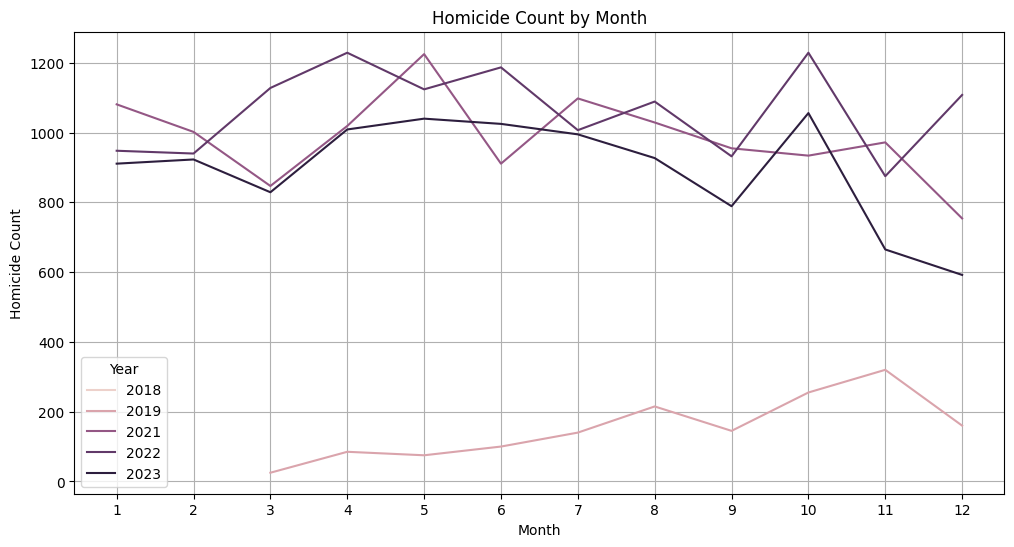

In [17]:
# Temporal trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='homicide_count', hue='year', data=hc_temporal_trends)
plt.title('Homicide Count by Month')
plt.xlabel('Month')
plt.ylabel('Homicide Count')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(title='Year')
plt.show()

C:\Users\avity\AppData\Local\Temp\ipykernel_26036\4076585082.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='homicide_count', data=hc_hourly_trends, palette='viridis')


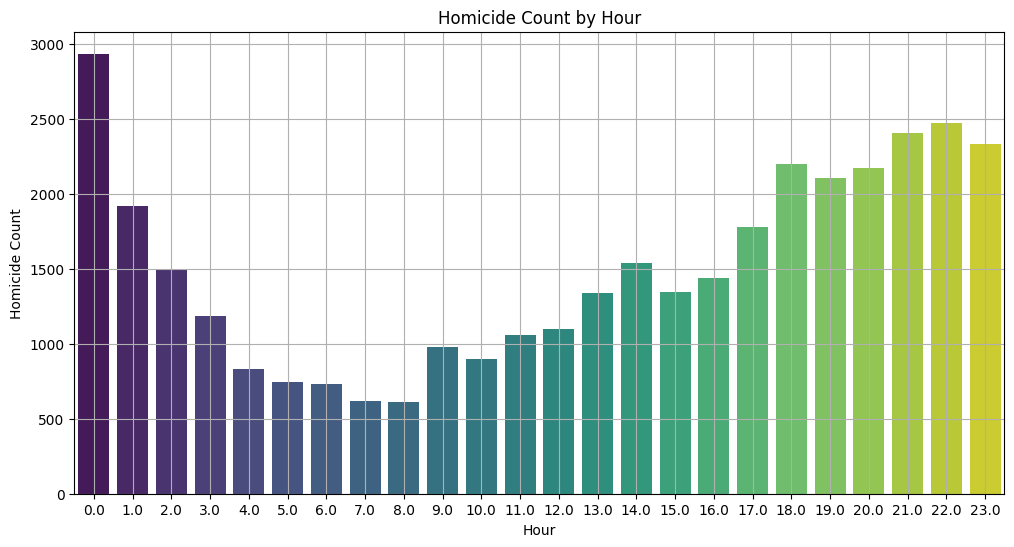

In [18]:
# Hourly trends
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='homicide_count', data=hc_hourly_trends, palette='viridis')
plt.title('Homicide Count by Hour')
plt.xlabel('Hour')
plt.ylabel('Homicide Count')
plt.grid(True)
plt.show()

C:\Users\avity\AppData\Local\Temp\ipykernel_26036\1284549951.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hc_spacial_trends.nlargest(10, 'homicide_count'), x='homicide_count', y='location_name', palette='viridis')


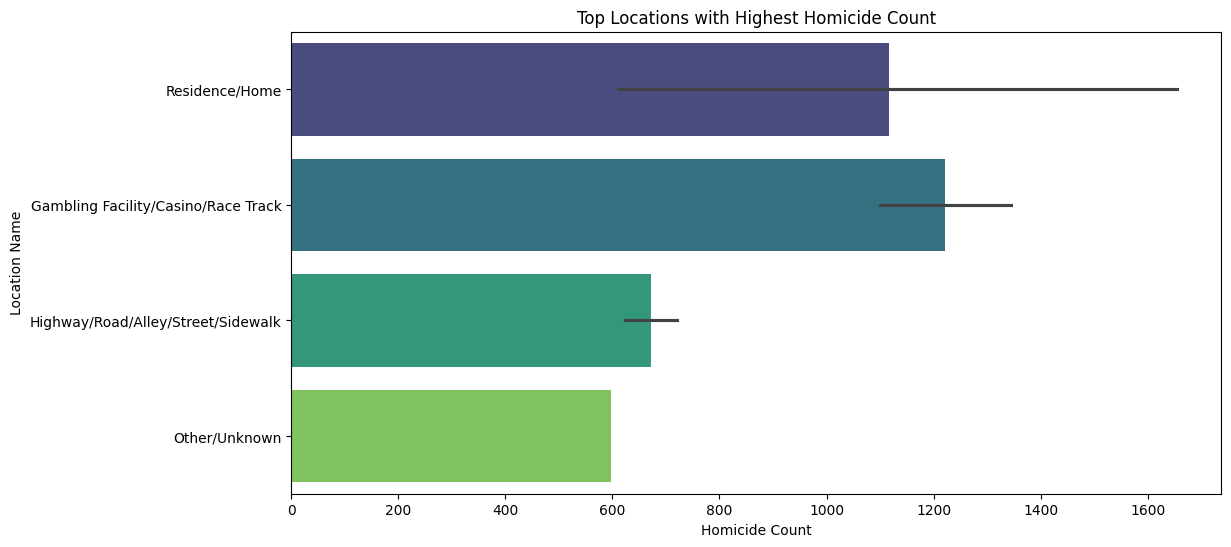

In [46]:
# Spacial trends
plt.figure(figsize=(12, 6))
sns.barplot(data=hc_spacial_trends.nlargest(10, 'homicide_count'), x='homicide_count', y='location_name', palette='viridis')
plt.title('Top Locations with Highest Homicide Count')
plt.xlabel('Homicide Count')
plt.ylabel('Location Name')
plt.show()

In [20]:
# Mapping the locations 
import folium
import geopandas as gpd

# Load the GeoJSON file
ga_counties = gpd.read_file('georgia_counties.geojson')

In [21]:
# Reproject to Georgia West State Plane (feet)
ga_counties = ga_counties.to_crs(epsg=4326) # WGS 84

# Calculate areas
ga_counties['area_sqft'] = ga_counties.geometry.area
ga_counties['area_sqmi'] = ga_counties['area_sqft'] / (5280 * 5280)  # convert sq ft to sq mi
ga_counties['area_sqkm'] = ga_counties['area_sqmi'] * 2.58999  # convert sq mi to sq km
ga_counties.drop('area_sqft', axis=1, inplace=True)
ga_counties.drop('area_sqkm', axis=1, inplace=True)
# Create final dataframe with original data plus areas
result = ga_counties[['name', 'id', 'STATE', 'TYPE', 'area_sqmi']]


C:\Users\avity\AppData\Local\Temp\ipykernel_26036\2582365513.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ga_counties['area_sqft'] = ga_counties.geometry.area


In [22]:
# Standardize county names in homicides_geo
homicides_cleaned['county_name'] = homicides_cleaned['county_name'].str.split(',').str[0].str.title().str.lower()
non_homicides_cleaned['county_name'] = non_homicides_cleaned['county_name'].str.split(',').str[0].str.title().str.lower()
ga_counties['name'] = ga_counties['name'].str.lower()

# add a column area_sqmi to homicides_cleaned and non_homicides_cleaned
homicides_cleaned = homicides_cleaned.merge(ga_counties[['name', 'area_sqmi']], left_on='county_name', right_on='name', how='left')
non_homicides_cleaned = non_homicides_cleaned.merge(ga_counties[['name', 'area_sqmi']], left_on='county_name', right_on='name', how='left')



In [23]:
# Aggregate homicides by county
county_trends = homicides_cleaned.groupby('county_name').size().reset_index(name='homicide_count')


In [24]:
# Merge homicide data with GeoJSON data
ga_counties = ga_counties.merge(county_trends, left_on='name', right_on='county_name', how='left')
ga_counties['homicide_count'] = ga_counties['homicide_count'].fillna(0)


In [25]:
import numpy as np
import folium

# Create base map
map = folium.Map(location=[32.7502, -83.5002], zoom_start=7)

# Get data range
min_count = ga_counties['homicide_count'].min()
max_count = ga_counties['homicide_count'].max()

# Create bins including zero if needed
if min_count == 0:
    # Add small epsilon to avoid log(0)
    bins = np.logspace(0, np.log10(max_count + 1), num=20)
    bins = np.insert(bins, 0, 0)  # Insert 0 as first bin
else:
    bins = np.logspace(np.log10(min_count), np.log10(max_count + 1), num=20)

# Remove duplicates and sort
bins = np.unique(bins)

# Add choropleth layer
folium.Choropleth(
    geo_data=ga_counties,
    data=ga_counties,
    columns=['name', 'homicide_count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Homicide Count',
    bins=bins
).add_to(map)

map.save('homicide_count_map.html')
map

In [26]:
# Add column indicating whether the offense is a homicide
non_homicides_cleaned['is_homicide'] = 0

# Combine the datasets
combined = pd.concat([homicides_cleaned.assign(is_homicide=1), non_homicides_cleaned], ignore_index=True)

In [27]:
# Now onto the modeling part
# Feature selection
new_df = combined[['incident_id', 'year', 'month', 'day', 'hour', 'suburban_area_flag', 'county_name','population', 'location_name', 'area_sqmi', 'is_homicide']]

In [28]:
# drop rows with missing values
new_df = new_df.dropna()

In [29]:
def create_more_features(df:pd.DataFrame) -> pd.DataFrame:
    df['time_of_day'] = pd.cut(df['hour'], 
                              bins=[0,6,12,18,24], 
                              labels=['night','morning','afternoon','evening'])
    
    df['is_weekend'] = pd.to_datetime(
        df[['year', 'month', 'day']]
    ).dt.dayofweek.isin([5,6]).astype(int)
    df['density_per_sqmi'] = df['population'] / df['area_sqmi']
    # Location features
    df['population_density'] = pd.qcut(df['density_per_sqmi'], q=5, 
                                     labels=['very_low', 'low', 'medium', 'high', 'very_high'])
    df.drop(columns=['density_per_sqmi'], inplace=True)
    df.drop(columns=['area_sqmi'], inplace=True)
    return df

In [30]:
new_df = create_more_features(new_df)
category_columns = [ 'county_name', 'location_name', 'time_of_day', 'population_density']
numerical_columns = [ 'month', 'day', 'hour', 'population']

In [31]:
new_df

,incident_id,year,month,day,hour,suburban_area_flag,county_name,population,location_name,is_homicide,time_of_day,is_weekend,population_density
0,112401812,2018,2,17,17.0,Y,hall,145970,Residence/Home,1,afternoon,1,medium
1,112401812,2018,2,17,17.0,Y,hall,147178,Residence/Home,1,afternoon,1,medium
2,112401812,2018,2,17,17.0,Y,hall,147037,Residence/Home,1,afternoon,1,medium
3,112401812,2018,2,17,17.0,Y,hall,147182,Residence/Home,1,afternoon,1,medium
4,112401812,2018,2,17,17.0,Y,hall,148922,Residence/Home,1,afternoon,1,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275800,154879398,2022,5,10,15.0,Y,henry,170245,Grocery/Supermarket,0,afternoon,0,high
275801,154879398,2022,5,10,15.0,Y,henry,172407,Grocery/Supermarket,0,afternoon,0,high
275802,154879398,2022,5,10,15.0,Y,henry,196347,Grocery/Supermarket,0,afternoon,0,high
275803,154879398,2022,5,10,15.0,Y,henry,170245,Grocery/Supermarket,0,afternoon,0,high


In [32]:
# One-hot encode categorical columns
df_encoded = pd.get_dummies(new_df, columns=category_columns, drop_first=True)

In [33]:
# Prepare the data for modeling
X = df_encoded.drop(columns=['incident_id', 'year', 'suburban_area_flag', 'is_homicide'])
y = df_encoded['is_homicide']

In [34]:
# Scale the numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

In [35]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [37]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

C:\Users\avity\AppData\Local\Temp\ipykernel_26036\3113438508.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance.head(10), palette='viridis')


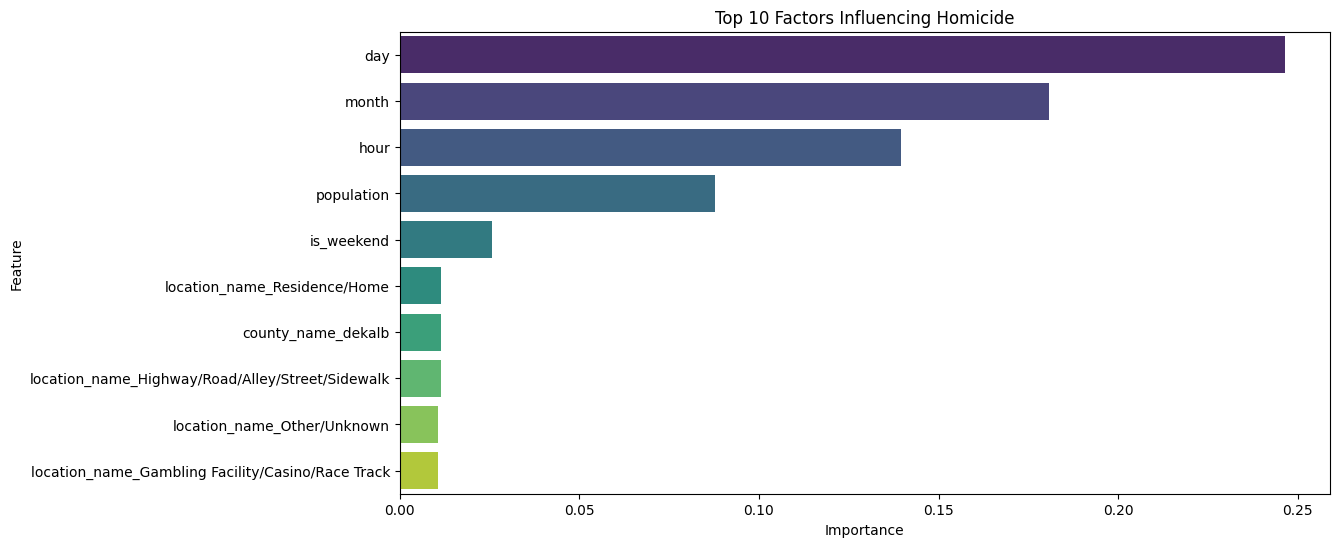

In [38]:
# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10), palette='viridis')
plt.title('Top 10 Factors Influencing Homicide')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [40]:
# Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

# Predict on the test set
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [41]:
# Calculate evaluation metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba)
}

print('\nEvaluation Metrics:')
for metric, value in metrics.items():
    print(f'{metric}: {value:.4f}')


Evaluation Metrics:
Accuracy: 0.9939
Precision: 0.9841
Recall: 0.9701
F1 Score: 0.9770
ROC AUC: 0.9996
